Implement the method of power iteration to approximate the top 10 PCs from HapMap3 data (see Galinsky et al. 2016a Am J Hum Genet). 


In cases of subtle structure (e.g. 2 populations with low Fst, or a single admixed population), investigate how accuracy of inferred ancestry varies with (a) number of SNPs used, (b) number of samples used, (c) whether or not other populations not relevant to the subtle structure are included in the data set. Discuss. 

*********
First part:
Include all ancestries?
Include all individuals? # does population size matter?
Include all 23 chromosomes?

#rare variants

How large is the data if we use all 23 chromosomes? Should we aim to use SNPs all 23 chromosomes for better accuracy?

(a) how do we assess the accuracy of inferred ancestry? How do we determine the inferred ancestry from PCs? clusters?
(c) other populations not relevant to the subtle structure <- does this mean a population that is very distant to the admixed population?


1. data pre-processing (data selection 1. standardize in some way? large/small population 2. which chromosome (based on number of SNPs) 3. how to handle rare/non-rare SNPs)
2. measures after method (accuracy?)
3. clarification on (c) distant to subtle structure. 


In [2]:
import numpy as np

In [3]:
import sys
#update the path to include the hw_data directory
path = "/Users/tinaryu/stat_gen/hw_data"

sys.path.append(path) 
#sys.path is a list of directories that Python searches when you use import statement
#append then adds the hw_data to the directories to be searched
from CB_02704 import *

In [4]:
CEU = read_geno_pop_chr('CEU',2) #northern European, USA
YRI = read_geno_pop_chr('YRI',2) ##Yoruba, Nigeria
CHB = read_geno_pop_chr('CHB',2) #Chinese, China

In [5]:
CEU_subset = CEU[:, :10]
YRI_subset = YRI[:, :10]
CHB_subset = CHB[:, :10]

# Horizontally stack the sliced arrays
combined = np.ma.hstack([CEU_subset, YRI_subset, CHB_subset])


calculate covariance matrix

In [18]:
def calc_af(geno): 
    '''Calculate the allele frequencies for each row in the geno'''
    return geno.mean(axis=1).filled(-1) / 2


# calculate allele frequency and standard deviation
p = calc_af(combined)
SD = np.sqrt(2*p*(1-p)) # assuming Hardy-Weinberg equilibrium

# normalize genotypes
X = ((combined - 2*p[:,None]) / SD[:,None]).filled(0)

# remove monomorphic rows
X = X[SD != 0,]
# calculate the covariance matrix
psi = X.transpose().dot(X) / float(X.shape[0])

In [7]:
psi

array([[ 1.04943248,  0.14421623,  0.10411379,  0.11943355,  0.12449176,
         0.12380583,  0.11804461,  0.11456665,  0.11464603,  0.10273008,
        -0.1436181 , -0.13266905, -0.13889074, -0.15679741, -0.1514123 ,
        -0.14640886, -0.17186863, -0.14080597, -0.15867191, -0.15553921,
        -0.05089041, -0.08978003, -0.02483916, -0.05791935, -0.04814931,
        -0.05276475, -0.10296403, -0.06725981, -0.0735196 , -0.05071238],
       [ 0.14421623,  1.09759931,  0.10867899,  0.10893344,  0.14452284,
         0.12066127,  0.09416893,  0.13115135,  0.13083536,  0.08052168,
        -0.14486507, -0.12325276, -0.14135572, -0.15646782, -0.13149105,
        -0.14989317, -0.12597396, -0.10752576, -0.13152391, -0.11833303,
        -0.09552731, -0.08755446, -0.06285496, -0.05877258, -0.11676745,
        -0.09845454, -0.0609748 , -0.09149732, -0.05361296, -0.10459078],
       [ 0.10411379,  0.10867899,  1.05271384,  0.11794839,  0.14106468,
         0.11341406,  0.10640231,  0.1211409 ,  0

using power iteration method to find the top eigenvector

In [172]:
def normalize_vec(v): # *
    '''normalize vector to have unit length'''
    v_to_return = v/np.sqrt((v**2).sum())
    return v_to_return

# multiply with covariance matrix and renormalize until convergence
def RunUntilConverge(b,psi):
    num_iters = 0 
    while(True):
        vec_old = b
        b = normalize_vec(psi.dot(vec_old))

        current_diff = ((b - vec_old)**2).mean()

        if current_diff < 1e-16:
            print("Power iteration: converged at iter="+str(num_iters))
            break
        if num_iters > 100000:
            print("Power iteration: did not converge")
            break
        num_iters+=1
    return b

def GetTop10PCs(psi):
    '''Get the top 10 principal components'''
    b = normalize_vec(np.random.rand(len(psi)))
    pcs = []
    #b = normalize_vec(np.random.rand(len(psi)))
    for i in range(10):
        b = RunUntilConverge(b, psi)
        pcs.append(b)
        d = b.T @ psi @ b
        psi = psi - d * np.outer(b, b)
    return pcs

In [173]:
top10PCs = GetTop10PCs(psi)

Power iteration: converged at iter=36
Power iteration: converged at iter=1
Power iteration: converged at iter=358
Power iteration: converged at iter=185
Power iteration: converged at iter=581
Power iteration: converged at iter=2
Power iteration: converged at iter=901
Power iteration: converged at iter=986
Power iteration: converged at iter=2
Power iteration: converged at iter=2990


In [201]:
#check if power iteration values are correct with built-in function
evals, evecs = np.linalg.eigh(psi)
evecs[-1]

array([ 0.18257419,  0.07574977, -0.38788669,  0.05931721,  0.2203037 ,
       -0.00859315,  0.06616441, -0.40025073,  0.23223392,  0.11081897,
        0.14463364,  0.15820633, -0.1646342 ,  0.39083665, -0.06905759,
       -0.0702014 ,  0.24508101,  0.07052177, -0.10170468, -0.02928646,
       -0.09013332, -0.15792842, -0.16859154,  0.05595353, -0.08333863,
        0.03849919, -0.25504705,  0.10342231,  0.1963777 , -0.16868865])

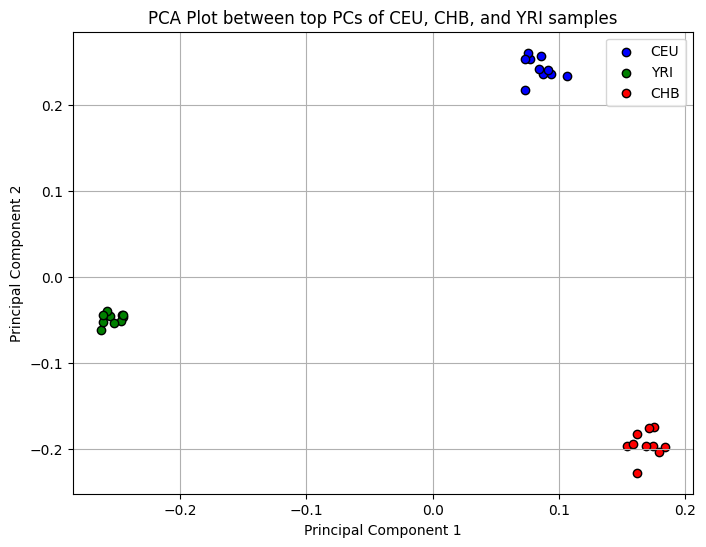

In [198]:
import matplotlib.pyplot as plt

# Calculate PCs (assuming you have the first two principal components in top10PCs) # Replace with your PC1 and PC2 arrays

# Define indices for each population
ceu_indices = range(0, CEU_subset.shape[1])
yri_indices = range(CEU_subset.shape[1], CEU_subset.shape[1] + YRI_subset.shape[1])
chb_indices = range(CEU_subset.shape[1] + YRI_subset.shape[1], combined.shape[1])

# Plot each population with a different color
plt.figure(figsize=(8, 6))

# CEU Population
plt.scatter(top10PCs[0][ceu_indices], top10PCs[1][ceu_indices], c='blue', label='CEU', edgecolor='k')
# YRI Population
plt.scatter(top10PCs[0][yri_indices], top10PCs[1][yri_indices], c='green', label='YRI', edgecolor='k')
# CHB Population
plt.scatter(top10PCs[0][chb_indices], top10PCs[1][chb_indices], c='red', label='CHB', edgecolor='k')

# Add labels and title
plt.title("PCA Plot between top PCs of CEU, CHB, and YRI samples")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()